In [15]:
import numpy as np
from scipy.stats import norm
import pandas as pd
from scipy.optimize import brentq
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import torch

In [11]:
df = pd.read_csv("treasury-rates.csv")

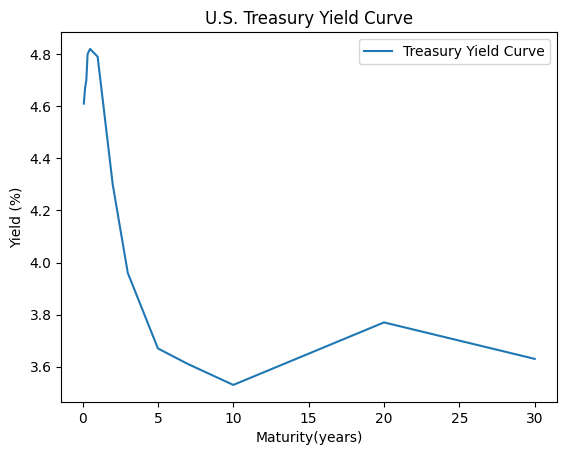

In [12]:
# Establishing yield curve based on  treasury rates for various maturities
treasury_data = pd.read_csv('treasury-rates.csv')

maturities=[]      #list of maturities with assigned interst rates
for row in treasury_data:
    maturities.append(row)
maturities.remove('Date')

treasury_dates = pd.to_datetime(treasury_data['Date'])
treasury_data['Date'] = pd.to_datetime(treasury_data['Date'])

num_rates=np.empty((len(treasury_dates), len(maturities)))       # list of intrest rates 
num_mat=[]                                                       # list of maturities
# Transferring interest rates to an array
def transfer_to_array(treasury_dates, maturities, treasury_data, num_rates):
    i = 0
    for date in treasury_dates:
        j = 0
        for maturity in maturities:
            num_rates[i][j] = treasury_data[maturity][i]
            j+=1
        i+=1

transfer_to_array(treasury_dates, maturities, treasury_data, num_rates)
# Setting maturities to numerical format(the unit is year)
for maturity in maturities:
    num_mat.append(str(maturity))

for i in range(len(num_mat)):
    if 'Mo' in num_mat[i]:
        num_mat[i] = float(num_mat[i].replace(' Mo',''))/12
        continue
    if 'Yr' in num_mat[i]:
        num_mat[i] = float(num_mat[i].replace(' Yr',''))
# Building yield curve based on obtained interest rates
yield_curve = CubicSpline(num_mat, num_rates[0,:], axis=0, extrapolate=None)

# Plotting obtained yield curve in a base scenario
plt.plot(num_mat, yield_curve(num_mat), label='Treasury Yield Curve')
plt.xlabel('Maturity(years)')
plt.ylabel('Yield (%)')
plt.title('U.S. Treasury Yield Curve')
plt.legend()
plt.show()

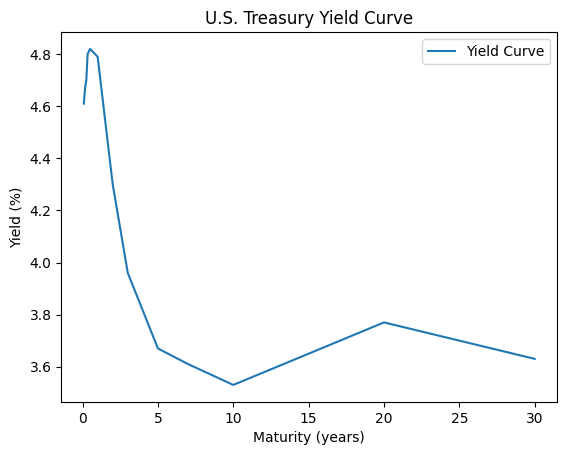

In [13]:
# Read Treasury data from CSV
treasury_data = pd.read_csv('treasury-rates.csv')

# Extract maturities
maturities = [col for col in treasury_data.columns if col != 'Date']

# Convert 'Date' column to datetime
treasury_data['Date'] = pd.to_datetime(treasury_data['Date'])
treasury_dates = pd.to_datetime(treasury_data['Date'])

# Initialize arrays for interest rates and maturities
num_rates = np.empty((len(treasury_dates), len(maturities)))
num_mat = []

# Transfer interest rates to an array
def transfer_to_array(treasury_dates, maturities, treasury_data, num_rates):
    for i, date in enumerate(treasury_dates):
        num_rates[i, :] = [treasury_data[maturity][i] for maturity in maturities]

transfer_to_array(treasury_dates, maturities, treasury_data, num_rates)

# Convert maturities to numerical format (in years)
for i, maturity in enumerate(maturities):
    if 'Mo' in maturity:
        num_mat.append(float(maturity.replace(' Mo', '')) / 12)
    elif 'Yr' in maturity:
        num_mat.append(float(maturity.replace(' Yr', '')))

# Build yield curve based on obtained interest rates
yield_curve_0 = CubicSpline(num_mat, num_rates[0, :], axis=0, extrapolate=None)

# Plotting the yield curve
plt.plot(num_mat, yield_curve_0(num_mat), label='Yield Curve')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield (%)')
plt.title('U.S. Treasury Yield Curve')
plt.legend()
plt.show()

In [16]:
def cds_pricingV2(notional, recovery_rate, spread, maturity):
    premium_leg = 0
    accrued_interest = 0
    protection_leg = 0
    LGD = notional * (1 - recovery_rate)  # Loss Given Default
    dt = 0.25  # payment frequency

    hazard_rate = spread / (1 - recovery_rate)
    time_steps = torch.arange(0.25, 4 * maturity + 0.25, 0.25)

    spread_tensor = torch.tensor(spread, requires_grad=True)  # Create tensor with requires_grad=True

    for t in time_steps:
        
        coupon = notional * spread_tensor * dt
        probability_of_survival = torch.exp(-hazard_rate * t)
        discount_factor = 1 / (1 + 0.01 * yield_curve_0(maturity)) ** maturity
        premium_leg_t = coupon * probability_of_survival * discount_factor

        default_with_premium_period = torch.exp(-hazard_rate * (t - 0.25)) - torch.exp(-hazard_rate * t)

        accrued_interest_t = 0.5 * coupon * default_with_premium_period * discount_factor  # default takes place in the middle of the premium period

        protection_leg_t = LGD * default_with_premium_period * discount_factor
        premium_leg += premium_leg_t
        accrued_interest += accrued_interest_t
        protection_leg += protection_leg_t

    cds_value = premium_leg + accrued_interest - protection_leg

    # Calculate sensitivity using PyTorch autograd
    sensitivity = torch.autograd.grad(cds_value, spread_tensor)[0]

    return cds_value, sensitivity.item()

notional = 10000000
recovery_rate = 0.4
spread = 0.005 * 30
maturity = 5

cds_value, sensitivity = cds_pricingV2(notional, recovery_rate, spread, maturity)
print(f'The present value of the CDS is {cds_value:.2f} USD')
print(f'Sensitivity of CDS with respect to spread: {sensitivity:.4f}')

The present value of the CDS is 1618.50 USD
Sensitivity of CDS with respect to spread: 33189422.0000
